# Momentum for Deep Learning Made Easy (How-To)
-----------

As neural networks have developed, so have the optimizers for gradient descent (if you need a refresher on gradient descent, please refer to my [book](https://cutt.ly/cg2nn-ch1-medium)). The use of an optimal optimizer is a constant area of research. In this article, we'll be covering momentum – a fundamental addition which made way for the famous ADAM optimizer.

Like many other improvements made in deep learning, momentum is not specific to deep learning, rather, it has been borrowed from other fields of research. It's originally known as an exponentially weighted average (EMA) algorithm and is used for the smoothing of graphs. In deep learning, it has the same function, except it's smoothing a graph which usually isn't plotted (i.e., the loss function).

In this article, we'll take the code first approach to understand momentum – the intuition along with its implementation.

The first thing we'll do is import our libraries which we'll use throughout this article. The libraries matplotlib, time and IPython are only imported for the ease of explanation but aren't required for the actual implementation of momentum.

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import time
from IPython import display

For the purposes of our explanation, we'll curate some points which we're going to graph. To accomplish this, we'll make some X and y data. Our X values will be a tensor consisting of decimal values (2 decimal places) between 0 and 1, with a step of 1e-2. Our y values will be a function of our X values.

In [8]:
X = torch.arange(0,1,1e-2)
y = 0.2*((X-0.5)**2)

Now that we have those, we're going to change 1 value in our y tensor to help us in our explanation. We'll change the 25th index, adding 2e-3 to the already existing value.

In [9]:
y[25] = y[25]+2e-3

Let's plot our X and y to see how they look.

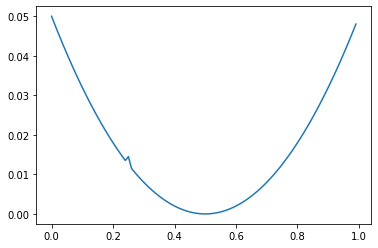

In [10]:
plt.plot(X,y)

What we're seeing is a parabola which has a bump at the 25th point. This is what we'll use to understand momentum.

## Exploring momentum

Now that we have our graph setup, we're ready to talk about the intuition behind momentum.

The parabola which we constructed will represent a valley. We're standing at the top of this valley and we're looking to roll a ball down the hill.

To simulate the rolling of a ball down the hill, I've come up with some code which will help us with that. The code is a very simplified version of gradient descent. The code works in the following manner – the ball keeps rolling down the hill as long as the gradient (i.e., the slope between 2 adjacent points) is a negative value. Essentially, the ball rolls down the hill for as long as it can.

Let's see it in action.

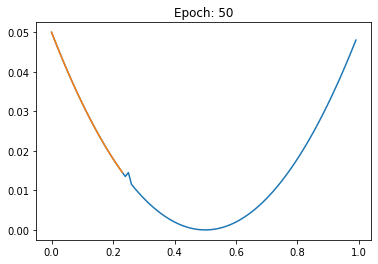

In [11]:
def gradient(x1, x2, y1, y2):
    return ((y2-y1)/(x2-x1)).item()
  
epochs = 50
pos = 0
path = [0]

for epoch in range(epochs+1):

    ##########plotting##########
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.plot(X, y, c='C0')
    plt.plot(X[path], y[path], c='C1')
    plt.title('Epoch: ' + str(epoch))
    plt.show()
    time.sleep(0.1)
    #############################
  
    cur_grad = gradient(X[pos], X[pos+1], y[pos], y[pos+1])  # calculate gradient
    # step
    if(cur_grad < 0.):
        pos += 1
  
    path.append(pos-1)

Hm… that's unfortunate. Our ball got stuck at the bump. I guess that was expected, but how do we overcome this? Considering this article is about momentum, then the answer to that question is probably momentum (you would be right if you assumed the answer to be momentum). The idea behind momentum is that if the ball has enough momentum, then it can overcome that small bump and get to the bottom of the valley.

So how do we accomplish this? What we're going to do is introduce 2 variables – velocity and momentum. The momentum variable we'll set to 0.6 (it must be a value between 0 and 1) and the velocity variable, we'll initialize it to 0. The formula behind momentum is the following:

*Momentum(velocity) + gradient(1-momentum)*

What we're doing is multiplying the velocity with the momentum and adding that to the gradient multiplied by 1 subtracted by the momentum value. That new number is our new velocity. The idea is that as long as our velocity is lower than 0, our ball will keep rolling down the hill.

Reusing the code from above, let's add in momentum and see it in action.

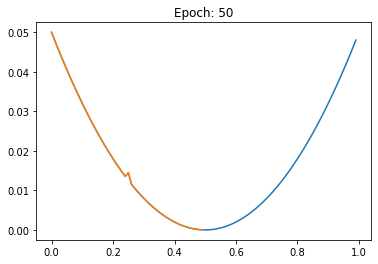

In [12]:
pos = 0
path = [0]

momentum = 0.6
velocity = 0

for epoch in range(epochs+1):

    ##########plotting##########
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.plot(X, y, c='C0')
    plt.plot(X[path], y[path], c='C1')
    plt.title('Epoch: ' + str(epoch))
    plt.show()
    time.sleep(0.1)
    #############################

    cur_grad = gradient(X[pos], X[pos+1], y[pos], y[pos+1])  # calculate gradient
    velocity = (momentum*velocity) + ((1-momentum)*cur_grad) # momentum equation
    # step
    if(velocity < 0.):
        pos += 1
  
    path.append(pos-1)

It worked! Our ball got to the bottom of the valley!

The code isn't complex, so I'm hoping that you can see how momentum fits in.

## How it works

The question now is, why did it work? Remember above when I said that momentum was used to smooth graphs? Well, that's exactly what we're doing with our value (i.e., loss function). We're smoothing it out, to the point that the ball doesn't actually see the bump.

Let's see what the ball sees.

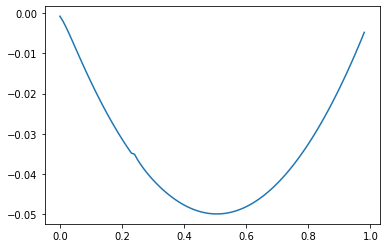

In [13]:
new_y = []
velocity = 0

for i in range(len(X)-1):
    cur_grad = gradient(X[i], X[i+1], y[i], y[i+1])
    velocity = (momentum*velocity) + ((1-momentum)*cur_grad)
    if(not new_y):
        prev_y = 0
    else:
        prev_y = new_y[-1]
    new_y.append((velocity*(X[i+1]-X[i]))+prev_y)

plt.plot(X[:-1], new_y)

Interesting. Our bump on the hill essentially disappeared. This is why our ball was able to cross it. This is also why the practice of smoothing our loss function is known as momentum in deep learning. It artificially gives the appearance of momentum (in reality, it's just a smoother graph).

## Exploring the math

Looking into the math of momentum gives us a better understanding as to what's happening when we use the formula.

Let's take a look at the formula for momentum. Our implementation above looked like the following:

*velocity = Momentum(velocity) + gradient(1-momentum)*

In practice, the portion of 1-momentum is omitted, simplifying it to this:

*velocity = Momentum(velocity) + gradient*

If you remember from above, we kept updating our velocity for every iteration/epoch. Keeping that in mind, for 5 iterations, our equation ends up looking like the following:

*momentum(momentum(momentum(momentum(momentum(velocity)+gradient4)+gradient3)+gradient2)+gradient1)+gradient*

Note: gradient1 represents the gradient in the past iteration, gradient2 represents the gradient in the past 2 iterations, etc.

If you recall from our implementation of momentum above, you'll remember that our initial velocity was set to 0. This means that for our example of 5 iterations, our velocity will be 0, resulting in our equation to look like this:

*momentum(momentum(momentum(momentum(momentum(0)+gradient4)+gradient3)+gradient2)+gradient1)+gradient*

Performing simple arithmetic, we know that anything multiplied by 0 is 0, which leaves only our gradient to exist in our first iteration. That results in the following equation:

*momentum(momentum(momentum(momentum(gradient4)+gradient3)+gradient2)+gradient1)+gradient*

The above equation can be rearranged to look like the following:

*gradient + momentum×gradient1 + momentum×momentum×gradient2 + momentum×momentum×momentum×gradient3 + momentum×momentum×momentum×momentum×gradient4*

If we simplify the math above, our equation looks like this:

*gradient + momentum(gradient1) + momentum<sup>2</sup>(gradient2) + momentum<sup>3</sup>(gradient3) + momentum<sup>4</sup>(gradient4)*

Interesting. Remember when I stated that momentum is just an equation for exponentially weighted averages? Well, that's exactly what we're seeing. We're seeing that as the iteration grows, the previous iteration gets raised to an exponent, causing it to get multiplied exponentially. Also, I stated above that the momentum value must be between 0 and 1. Any value which is between 0 and 1 (even if it's between 0 and -1) will get exponentially smaller as the number in the exponent grows. This means that the velocities in the past influence the current velocity (although exponentially less as the iterations grow) and thus result in a smoother graph.

Plotting out our momentum values, we can see that in our case, when we set the momentum to 0.6, around the 6th iteration in the past, our value is essentially 0. This shows that although the values in the past iterations influence the current iteration, after a certain number of iterations, that influence becomes negligible.

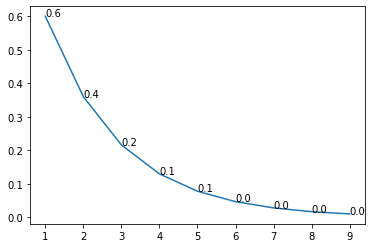

In [14]:
momentum = 0.6
power = range(1,10)
decay = []

for i in power:
    decay.append(momentum**i)
plt.plot(power, decay)

for x,y in zip(power, decay):
    label = "{:.1f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,0))
    
plt.show()

Hope that explanation made sense. Stepping through it always helps. If you're still having a bit of trouble, maybe write it out by hand. That helped me when I was learning momentum.

## Implementing it in code
Let's take a look at how momentum works in our model training loop.

First thing first, we need some data. We're going to use PyTorch's randn function to create a tensor for our X values. The tensor will consist of random values, and will have the shape 1000×1000. We'll also create a tensor for our y values having the shape 1000×1. We'll make it binary – half the values will be set 0, while the other half will be set to 1.

In [28]:
dim = 1000
X = torch.randn((dim,dim), dtype=float)
y = torch.cat((torch.zeros(dim//2, dtype=float), torch.ones(dim//2, dtype=float)))

Awesome. Now that we have our data, we're going to use PyTorch's Dataset and DataLoader functionality so that we can perform batch gradient descent (if you're unfamiliar with PyTorch's Dataset and DataLoader classes, then please check out [my article](https://cutt.ly/cg2ai-pytorch-dataloader-medium) which explains it in detail).

In [29]:
class ExampleDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


data = ExampleDataset(X, y)
data_loader = DataLoader(dataset=data, batch_size=64, shuffle=True)

We’re now ready to create our neural network architecture using PyTorch's nn.Module class. Our architecture will be very straightforward. It's a simple feed forward network consisting of 1 hidden layer, which will be half the size of our input layer (i.e., 500). To keep things simple, the activation function we'll use is the sigmoid function.

In [17]:
class Model(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.hidden_layer = nn.Linear(dim, dim//2)
        self.last_layer = nn.Linear(dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.sigmoid(self.hidden_layer(X))
        out = self.sigmoid(self.last_layer(out))
        return out

## Training without momentum

For the first round of training, we're going to train without momentum. It allows us to set a benchmark and compare the performance with and without momentum.

Now, something we're going to do is use the GPU (i.e., CUDA) for this example. It's easy to use and it will allow us to train our model faster. All we need to do is place our model and our data onto the GPU by calling the .to function. This will alert PyTorch that we want to use the GPU when training and PyTorch will take care of the rest.

Note: to turn the GPU on in Google Colab, go to Edit > Notebook settings and then chagne the hardware settings to GPU (the GPU is free to use).

We'll instantiate our Model class, initialize our loss function and optimizer. We'll train for a total 2000 epochs with a learning rate of 1e-5. 

Note: momentum should be done with a small learning rate, otherwise we won't see optimal results.


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2000
learning_rate = 1e-5

model = Model(dim).to(device)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Let's train our model!

In [31]:
epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.69609
Train: epoch: 100 - loss: 0.69451
Train: epoch: 200 - loss: 0.69370
Train: epoch: 300 - loss: 0.69344
Train: epoch: 400 - loss: 0.69330
Train: epoch: 500 - loss: 0.69313
Train: epoch: 600 - loss: 0.69276
Train: epoch: 700 - loss: 0.69286
Train: epoch: 800 - loss: 0.69267
Train: epoch: 900 - loss: 0.69253
Train: epoch: 1000 - loss: 0.69249
Train: epoch: 1100 - loss: 0.69232
Train: epoch: 1200 - loss: 0.69206
Train: epoch: 1300 - loss: 0.69231
Train: epoch: 1400 - loss: 0.69201
Train: epoch: 1500 - loss: 0.69211
Train: epoch: 1600 - loss: 0.69189
Train: epoch: 1700 - loss: 0.69201
Train: epoch: 1800 - loss: 0.69127
Train: epoch: 1900 - loss: 0.69150
Train: epoch: 2000 - loss: 0.69125


We're seeing a bit of a ping pong effect in our loss function.

Let's plot our loss function and see how it looks.

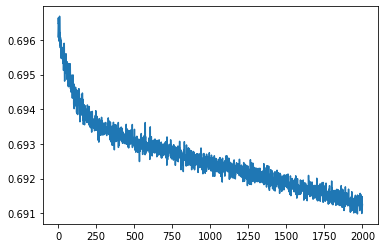

In [32]:
plt.plot(epoch_loss)

Now that we look closer at our loss function, we see it ping ponging a lot. This ping pong effect is exactly what momentum is meant to remedy.

## Training with momentum
This time let's train with momentum. We'll reinitialize our model, loss and optimizer, but this time, we'll add momentum. We'll set the momentum to 0.9.

To implement the momentum algorithm, we're going to need access to the gradients. The way we'll access them is by calling the named_parameters function on our model variable and then iterating through it to retrieve our gradients. If you remember the fundamentals of deep learning (if you don't, you can always refer to [my free book](https://cutt.ly/cg2nn-ch1-medium)), then you must've remembered that our gradients are connected to our weights. For our model, we have 2 sets of weights – 1 set for the weights connecting the input layer to the hidden layer and a 2nd set for the weights connecting the hidden layer to the output layer. If we iterate through the named_parameters, we'll see that it actually contains 4 items – the 2 sets of weights and the biases for those 2 sets of weights (2 biases in our case).

To hold our velocities, we're going to use a dictionary. It'll hold our weights, so that we can use and update them.

In [36]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate variable from above
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
momentum = 0.9

Let's train our model with momentum!

In [37]:
epoch_loss = []
velocities = {}

model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        for name, w in model.named_parameters():
            if name not in velocities:
                velocities[name] = torch.zeros_like(w.grad).detach()
            velocities[name].mul_(momentum).add_(w.grad)
            w.grad = velocities[name]
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.69902
Train: epoch: 100 - loss: 0.69475
Train: epoch: 200 - loss: 0.69378
Train: epoch: 300 - loss: 0.69316
Train: epoch: 400 - loss: 0.69348
Train: epoch: 500 - loss: 0.69280
Train: epoch: 600 - loss: 0.69277
Train: epoch: 700 - loss: 0.69246
Train: epoch: 800 - loss: 0.69217
Train: epoch: 900 - loss: 0.69184
Train: epoch: 1000 - loss: 0.69207
Train: epoch: 1100 - loss: 0.69147
Train: epoch: 1200 - loss: 0.69160
Train: epoch: 1300 - loss: 0.69112
Train: epoch: 1400 - loss: 0.69092
Train: epoch: 1500 - loss: 0.69074
Train: epoch: 1600 - loss: 0.69056
Train: epoch: 1700 - loss: 0.69046
Train: epoch: 1800 - loss: 0.68996
Train: epoch: 1900 - loss: 0.68954
Train: epoch: 2000 - loss: 0.68988


The output so far looks promising. We see no ping ponging between the loss numbers.

Let's plot our graph and see the full picture.

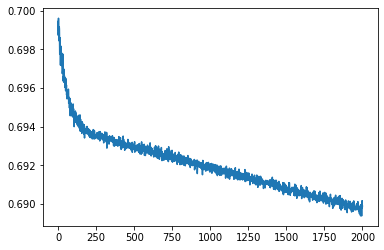

In [38]:
plt.plot(epoch_loss)

Amazing! The graph looks a lot smoother. Momentum works!

## Momentum in PyTorch
Thanks to the PyTorch team, we don't need to implement momentum from scratch whenever we use it. We can use SGD's built-in functionality for momentum. All we need to do is set the momentum parameter and we're good to go.

In [39]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate and momentum variables from above
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

Let's see it in action.

In [40]:
epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.70020
Train: epoch: 100 - loss: 0.69590
Train: epoch: 200 - loss: 0.69464
Train: epoch: 300 - loss: 0.69366
Train: epoch: 400 - loss: 0.69249
Train: epoch: 500 - loss: 0.69130
Train: epoch: 600 - loss: 0.68982
Train: epoch: 700 - loss: 0.68874
Train: epoch: 800 - loss: 0.68764
Train: epoch: 900 - loss: 0.68643
Train: epoch: 1000 - loss: 0.68507
Train: epoch: 1100 - loss: 0.68375
Train: epoch: 1200 - loss: 0.68260
Train: epoch: 1300 - loss: 0.68138
Train: epoch: 1400 - loss: 0.68035
Train: epoch: 1500 - loss: 0.67914
Train: epoch: 1600 - loss: 0.67798
Train: epoch: 1700 - loss: 0.67637
Train: epoch: 1800 - loss: 0.67509
Train: epoch: 1900 - loss: 0.67358
Train: epoch: 2000 - loss: 0.67289


It performs as expected.

Here's the loss plotted.

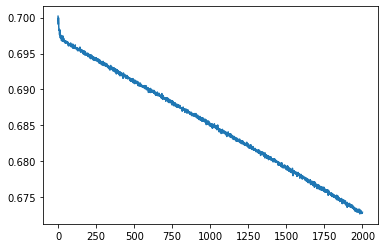

In [41]:
plt.plot(epoch_loss)

Awesome! Works more or less like our momentum we made from scratch. It actually works better than our momentum, because the PyTorch code uses some tricks to improve performance. Nonetheless, congratulations! You now know the inner working of momentum.

## Momentum flavours
If you look at the SGD optimizer for PyTorch, you'll see that you can pass it a few arguments: momentum, dampening, weight_decay (read more about weight decay [here](https://cutt.ly/cg2ai-weight-decay-medium)), and nesterov. We already covered momentum, but dampening and nesterov are additions to the momentum algorithm.

To simplify both, the momentum equation with the addition of a value for dampening and nesterov set to true looks like the following:

*gradient + momentum(**momentum(velocity) + gradient**(1-dampening))*

That's a mouthful. I bolded the original momentum equation for ease of reference. Maybe looking at the source code for PyTorch's SGD class will help. Run the following cell and scroll down until you see the code for momentum.


In [27]:
torch.optim.SGD??

## Momentum in practice
In practice, SGD with momentum is no longer used to get optimal results, rather the ADAM optimizer (and its flavours) is now the standard. The ADAM optimizer makes use of momentum along with other improvements. Having said that, if someone was to use SGD with momentum, then it's agreed upon that the value 0.9 generally works well.

That wraps up everything momentum. Hope that clears up the topic of momentum. Again, stepping through the code always helps. Maybe go through it and tweak the numbers to really get a good understanding of momentum. Playing with the code is always the best way to learn.